# Title :

---

## Introduction

lorem ipsum

## Methodology

lorem ipsum

### Preprocessing

In [72]:
# Import Library
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
# Open dataset
df = xr.open_dataset("cru_ts4.09.1901.2024.tmp.dat.nc") # lazy loading, tmp files
uk = gpd.read_file("geoBoundaries-GBR-ADM0-all/geoBoundaries-GBR-ADM0.shp").to_crs(epsg=4326) # uk boundaries shp

minx, miny, maxx, maxy = uk.total_bounds
print("Lon:", minx, maxx, "Lat:", miny, maxy)

# Subset UK
df_uk = df.sel(
    lon=slice(minx, maxx),
    lat=slice(miny, maxy)
)

print(df_uk)

Lon: -8.645449000271071 1.754925999835052 Lat: 49.88482600011986 60.843381000432885
<xarray.Dataset> Size: 14MB
Dimensions:  (lon: 21, lat: 22, time: 1488)
Coordinates:
  * lon      (lon) float32 84B -8.25 -7.75 -7.25 -6.75 ... 0.25 0.75 1.25 1.75
  * lat      (lat) float32 88B 50.25 50.75 51.25 51.75 ... 59.75 60.25 60.75
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2024-12-16
Data variables:
    tmp      (time, lat, lon) float32 3MB ...
    stn      (time, lat, lon) float64 5MB ...
    mae      (time, lat, lon) float32 3MB ...
    maea     (time, lat, lon) float32 3MB ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:tmp.2503051121.dtb
    history:      Wed  5 Mar 13:28:04 GMT 2025 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
  

#### Datasets Description

1. <div align="justify"> `tmp` : The temperature variable `tmp` represents the monthly mean surface air temperature recorded at each grid cell across UK domain. Observations are provided on a regular latitude-longitude grid and span the period from January 1901 to December 2024. </div><br>
2. <div align="justify"> `lat`/`lon` : Latitude/Longitude </div><br>
3. <div align="justify"> `time` : The time dimension represents monthly observations spanning January 1901 to December 2024. Each timestamp corresponds to a monthly average temperature value.</div><br>
4. <div align="justify"> `stn` : The station count variable represents the number of observational weather stations contributing to the interpolation process used to estimate temperature at each grid cell. Higher station counts indicate stronger observational support and potentially lower uncertainty, whereas lower values suggest greater reliance on spatial interpolation and therefore increased uncertainty. For example, `stn` = 12 i.e. temperature estimate derived using data from 12 nearby stations.</div><br>



In [93]:
# Time Variable
df_uk.time.min(), df_uk.time.max()
df_uk.time.values[:24]

array(['1901-01-16T00:00:00.000000000', '1901-02-15T00:00:00.000000000',
       '1901-03-16T00:00:00.000000000', '1901-04-16T00:00:00.000000000',
       '1901-05-16T00:00:00.000000000', '1901-06-16T00:00:00.000000000',
       '1901-07-16T00:00:00.000000000', '1901-08-16T00:00:00.000000000',
       '1901-09-16T00:00:00.000000000', '1901-10-16T00:00:00.000000000',
       '1901-11-16T00:00:00.000000000', '1901-12-16T00:00:00.000000000',
       '1902-01-16T00:00:00.000000000', '1902-02-15T00:00:00.000000000',
       '1902-03-16T00:00:00.000000000', '1902-04-16T00:00:00.000000000',
       '1902-05-16T00:00:00.000000000', '1902-06-16T00:00:00.000000000',
       '1902-07-16T00:00:00.000000000', '1902-08-16T00:00:00.000000000',
       '1902-09-16T00:00:00.000000000', '1902-10-16T00:00:00.000000000',
       '1902-11-16T00:00:00.000000000', '1902-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')

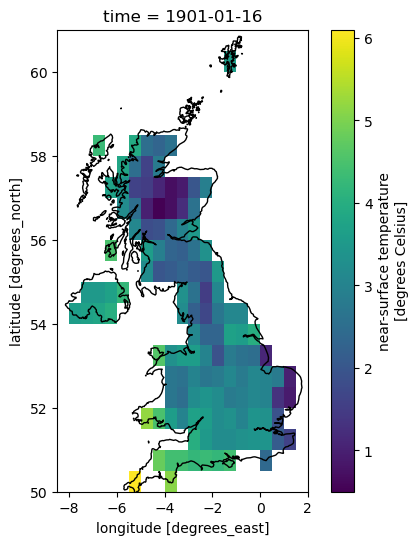

In [94]:
# Plotting time = 0 with UK boundaries
from shapely.geometry import Point

# Take one time slice just to build the spatial grid
da0 = df_uk["tmp"].isel(time=0)

# Build lon/lat mesh
lon2d, lat2d = np.meshgrid(df_uk["lon"].values, df_uk["lat"].values)

# Make points GeoDataFrame
pts = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(lon2d.ravel(), lat2d.ravel()),
    crs="EPSG:4326"
)

# Keep only points inside the UK polygon
inside = pts.within(uk.geometry.iloc[0]).values.reshape(lat2d.shape)

# Mask: set outside polygon to NaN
da0_masked = da0.where(inside)

fig, ax = plt.subplots(figsize=(6,6))

da0_masked.plot(ax=ax)                 # xarray draws on this Axes
uk.boundary.plot(ax=ax, color="black", linewidth=1)

plt.show()


In [121]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# function to clip raster to polygon
def clip_raster_to_geom(ax, geom, collection_index=0):
    """Clip the first QuadMesh/collection produced by xarray.plot() to a (Multi)Polygon."""
    geoms = geom.geoms if geom.geom_type == "MultiPolygon" else [geom]
    vertices, codes = [], []

    for poly in geoms:
        x, y = poly.exterior.coords.xy
        verts = np.column_stack([x, y])
        c = np.full(len(verts), Path.LINETO, dtype=np.uint8)
        c[0] = Path.MOVETO
        vertices.append(verts)
        codes.append(c)

    vertices = np.vstack(vertices)
    codes = np.concatenate(codes)

    patch = PathPatch(Path(vertices, codes), transform=ax.transData)
    ax.collections[collection_index].set_clip_path(patch)

Lon: -8.645449000271071 -0.738072999669157 Lat: 54.63919599969569 60.843381000432885


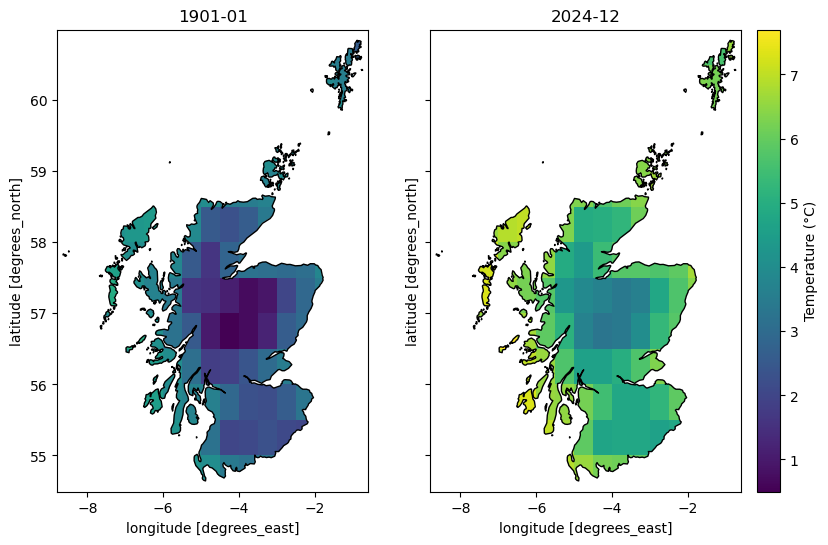

<xarray.Dataset> Size: 7MB
Dimensions:  (lon: 17, lat: 13, time: 1488)
Coordinates:
  * lon      (lon) float32 68B -8.75 -8.25 -7.75 -7.25 ... -1.75 -1.25 -0.75
  * lat      (lat) float32 52B 54.75 55.25 55.75 56.25 ... 59.75 60.25 60.75
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2024-12-16
Data variables:
    tmp      (time, lat, lon) float32 1MB ...
    stn      (time, lat, lon) float64 3MB ...
    mae      (time, lat, lon) float32 1MB ...
    maea     (time, lat, lon) float32 1MB ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:tmp.2503051121.dtb
    history:      Wed  5 Mar 13:28:04 GMT 2025 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    cont

In [122]:
# Scotland comparison plot (1901-01 vs 1014-12) with clipped coastline
uk_ = gpd.read_file("geoBoundaries-GBR-ADM1-all/geoBoundaries-GBR-ADM1.shp").to_crs(epsg=4326) # uk boundaries shp
scot = uk_[uk_["shapeName"] == "Scotland"].dissolve() # dissolve to single polygon

minx1, miny1, maxx1, maxy1 = scot.total_bounds
print("Lon:", minx1, maxx1, "Lat:", miny1, maxy1)
geom = scot.geometry.iloc[0]

pad = 0.15 # add some padding around the polygon to make sure we get all of it (and a bit of sea around)
minx1, maxx1 = minx1 - pad, maxx1 + pad
miny1, maxy1 = miny1 - pad, maxy1 + pad

df_scot = df.sel(lon=slice(minx1, maxx1), lat=slice(miny1, maxy1))

# pick two times
ds_0 = df_scot["tmp"].isel(time=0) # 1901-01
ds_n = df_scot["tmp"].isel(time=1487) # 2024-12

# compute shared color scale
vmin = float(min(ds_0.min(), ds_n.min()))
vmax = float(max(ds_0.max(), ds_n.max()))

# create side-by-side plots
fig, axes = plt.subplots(
    1, 2,
    figsize=(10, 6),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.05}
)

# first plot
im0 = ds_0.plot(
    ax=axes[0],
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False
)
axes[0].set_title("1901-01")

# second plot
im1 = ds_n.plot(
    ax=axes[1],
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False
)
axes[1].set_title("2024-12")

# clip both to Scotland
clip_raster_to_geom(axes[0], geom)
clip_raster_to_geom(axes[1], geom)

# draw boundary
scot.boundary.plot(ax=axes[0], color="black", linewidth=1)
scot.boundary.plot(ax=axes[1], color="black", linewidth=1)

# same extent
for ax in axes:
    ax.set_xlim(minx1, maxx1)
    ax.set_ylim(miny1, maxy1)

# shared colorbar
fig.colorbar(
    axes[1].collections[0],
    ax=axes,
    label="Temperature (°C)",
    fraction=0.04,
    pad=0.02
)

plt.show()

print(df_scot)

<div align="justify"> The side-by-side maps show a clear warming signal between January 1901 and December 2024 across Scotland. While the spatial structure is broadly consistent in both periods-temperatures tend to be higher in coastal grid cells and lower inland. The overall distribution in 2024 is shifted upward, indicating higher temperatures almost everywhere. </div><br>

<div align="justify"> This combination of persistent spatial pattern (coast-inland contrast) and systematic temporal change motivates a Bayesian hierarchical spatio-temporal model that can: <br>

1. quantify the long-term warming trend,
2. separate large-scale temporal effects from local spatial variation,
3. assess whether coastal-inland differences remain stable or evolve over time.